On policy prediction with function approximation : Linear TD

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time as time

# 1. Defining the environment

We study the 1000-steps random walk (ex 9.1 in Sutton's book).

The discounting factor is $\gamma$, and we denote $\pi$ the policy to be evaluated.

In [28]:
#discount factor
gamma=0.99999999

#define number of states
nState=1000

#define policy
#random walk, move 1 to 100 steps to the left or to the right
P_pi = np.zeros((nState+1,nState+1))
nStep=100

for i in range(1,nStep+1):
    P_pi+=(1.0/(nStep*2.0)) * np.diag(np.ones(nState+1-i),i)
    P_pi+=(1.0/(nStep*2.0)) * np.diag(np.ones(nState+1-i),-i)

P_pi[0,:]=0
P_pi[:,0]=0
P_pi[0,0]=1

for i in range(0,nStep):
    P_pi[i+1,0]=0.5-(i)/(2.0*nStep)
    P_pi[n-i,0]=0.5-(i)/(2.0*nStep)


#define reward vector
#reward of +1 if reach right end, -1 if reach left end
r_pi=np.zeros(nState+1)
for i in range(0,nStep):
    r_pi[i+1]=-(0.5-(i)/(2.0*nStep))
    r_pi[n-i]=0.5-(i)/(2.0*nStep)


#compute true value function v_pi
#we compute exact valeus by inverting the transition matrix
v_pi = np.linalg.solve( (np.eye(nState+1)-gamma*P_pi),r_pi)

    
#number of aggregated states
k=10

#define Phi matrix
# /!\ for the following formula to work correctly, k must be divider of nState /!\
Phi=np.vstack((np.zeros(k),np.kron(np.eye(k),np.ones((nState/k,1)))))
u=np.zeros(nState+1).reshape((nState+1,1))
u[0]=1
Phi=np.hstack((u,Phi))

Denote $d$ the stationnaty distribution of states under $\pi$. We define $D$ as the diagonal matrix which diagonal entries are $d$ :

$$
D = 
\left(
\begin{array}{ccc}
d(s_{1}) & & 0\\
& \ddots & & \\
0 & & d(s_{|\mathcal{S}|})
\end{array}
\right)
$$

Then, by definition of $d$, we have $d^{T} = d^{T} P$. That is, $d$ is a left eigenvector of $P$ associated to eigevalue $1$.

In [7]:
#compute stationary distribution
#Recall state 0 is terminal and absorbent under policy pi
#If we just apply the above formula, we will get d = [1 0 0 0 0 ...]
#Therefore, we slightly tweak the transition matrix, by adding a deterministic transition 
#from the terminal state to the initial state

#Note that this works with any distribution for the initial state
#However, a different starting distribution will yield a different stationary distribution
P_pi[0,0]=0
P_pi[0,n/2]=1

#this will typically yield complex eigenvectors
[e,v]=np.linalg.eig(P_pi.T)
d_=np.abs(v[:,0])/np.sum(np.abs(v[:,0]))

#compute D matrix
D=np.diag(d_)

#make the transition matrix normal again
P_pi[0,:]=0
P_pi[0,0]=1

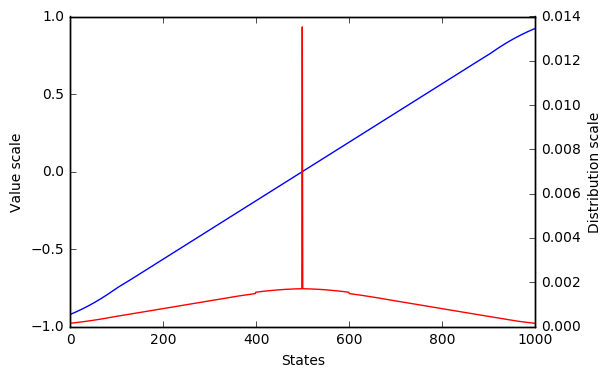

In [21]:
#Here we plot the stationary distribution and value function
#we don't plot state 0 as it is the terminal state (thus its value is 0)

fig, ax1 = plt.subplots()
#plot value function
ax1.plot(v_pi[range(1,n+1)],'b-')
ax1.set_xlabel('States')
ax1.set_ylabel('Value scale')
#plot stationary distribution
ax2 = ax1.twinx()
ax2.plot(d_[range(1,n+1)],'r')
ax2.set_ylabel('Distribution scale')

#fig.tight_layout()
plt.show()

The Mean Squared Value Error is actually a scalar product, so it can be computed using matrix multiplication :

\begin{align}
MSVE(\theta) & = \sum_{s} d(s) \Big( \hat{v}(\theta,s)-v_{\pi}(s) \Big)^{2} \\
& = (\hat{v} - v_{\pi})^{T} \cdot D \cdot (\hat{v} - v_{\pi}) \\
& = (\Phi \theta - v_{\pi})^{T} \cdot D \cdot (\Phi \theta - v_{\pi})
\end{align}

In [42]:
def MSVE(theta,D,Phi,v_pi):
    v_hat=Phi.dot(theta)
    return (v_hat-v_pi).T.dot(D).dot(v_hat-v_pi)

# 2. Learning algorithms

We implement Monte-Carlo and 1-step Temporal different algorithms for the on-policy evaluation task.

In [47]:
#Gradient MC Algorithm
nEp_mc=5000 #number of episodes
d_mc=np.zeros(n+1) #counts how many times each state is visited
alpha_mc=2*10**(-4) #learning rate

MSVE_mc=np.zeros(nEp_mc)

#initialize weights
theta_mc_approx=np.zeros(k+1)

print 0,'/',nEp_mc
for e in range(nEp_mc):
    if((e+1) % (nEp_mc/10) == 0):
        print e+1,'/',nEp_mc
    
    #generate an episode
    s=n/2
    u=[]
    while(s != 0):
        u.append(s)
        d_mc[s] +=1
        
        #make a move according to policy
        s_=np.random.choice(n+1,1,True,P_pi[s,:])[0]
        
        #observe reward
        #negative reward can only be obtained if s<=nStep
        r = (s_==0) * (1-2*(s<=nStep))
        
        #update state
        s=s_
    
    d_mc[0]+=1
    #compute reward
    G=r #-1 if s<0
    
    #apply MC backup
    for s in u:
        theta_mc_approx = theta_mc_approx + alpha_mc * (G-np.dot(theta_mc_approx,Phi[s,:]))*(Phi[s,:])
    
    #compute approximated value function
    v_mc_approx=np.dot(Phi,theta_mc_approx)

    #compute MSVE
    MSVE_mc[e] = np.sum( (d_mc/np.sum(d_mc)) * np.square(v_mc_approx-v_pi) )

#compute approximated value function
v_mc_approx=np.dot(Phi,theta_mc_approx)

0 / 5000
500 / 5000
1000 / 5000
1500 / 5000
2000 / 5000
2500 / 5000
3000 / 5000
3500 / 5000
4000 / 5000
4500 / 5000
5000 / 5000


In [44]:
#semi-gradient TD(0)
nEp_td=5000 #number of episodes
alpha_td=0.01
d_td=np.zeros(n+1)
MSVE_td=np.zeros(nEp_td)

#initialize weights
theta_td_approx=np.zeros(k+1)

print 0,'/',nEp_td
for e in range(nEp_td):
    
    if( (e+1) % (nEp_td/10) == 0):
        print e+1,'/',nEp_td
    
    #intialize state
    s=n/2
    
    while(s !=0):
        #u.append(s)
        d_td[s] +=1
        
        #make a move according to policy
        s_=np.random.choice(n+1,1,True,P_pi[s,:])[0]
        
        #observe reward
        #negative reward can only be obtained if s<=nStep
        r = (s_==0) * (1-2*(s<=nStep))
        
        #perform TD update
        theta_td_approx = theta_td_approx + alpha_td * (r+gamma*np.dot(theta_td_approx,Phi[s_,:])-np.dot(theta_td_approx,Phi[s,:]))*(Phi[s,:])
        
        #update state
        s=s_
        
    d_td[0]+=1
    
    #compute approximated value function
    v_td_approx=np.dot(Phi,theta_td_approx)

    #compute MSVE
    MSVE_td[e] = np.sum( (d_td/np.sum(d_td)) * np.square(v_td_approx-v_pi) )
    

#compute value function for each state
v_td_approx=np.dot(Phi,theta_td_approx)

0 / 5000
500 / 5000
1000 / 5000
1500 / 5000
2000 / 5000
2500 / 5000
3000 / 5000
3500 / 5000
4000 / 5000
4500 / 5000
5000 / 5000


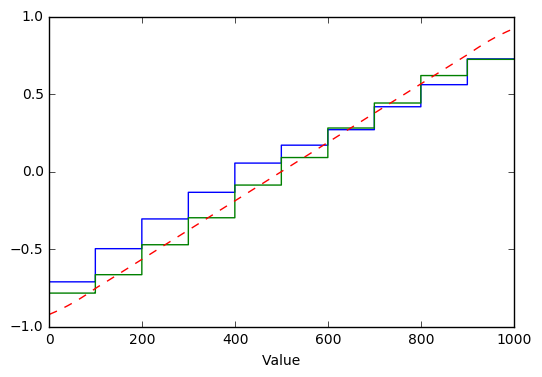

In [49]:
#plot results
plt.step(v_td_approx[range(1,n+1)], 'b-') #TD approximation
plt.step(v_mc_approx[range(1,n+1)], 'g-') #MC approximation
plt.plot(v_pi[range(1,n+1)], 'r--') #true value function
plt.xlabel('State (s)')
plt.xlabel('Value')
plt.show()

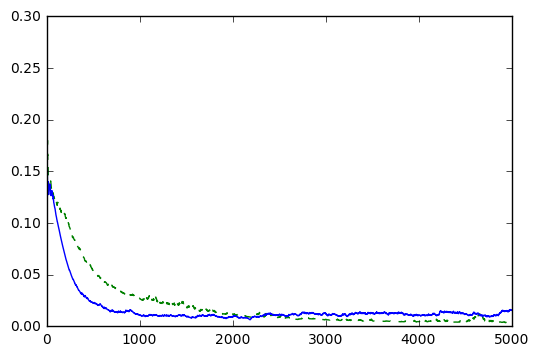

In [48]:
RMS_mc=np.sqrt(MSVE_mc)
RMS_td=np.sqrt(MSVE_td)

plt.plot(MSVE_mc,'g--')
plt.plot(MSVE_td,'b-')
plt.show()

# 3. Theoretical analysis

In [50]:
#Compute theoretical MC
theta_mc_star = np.linalg.inv(np.linalg.multi_dot((Phi.T,D,Phi))).dot(Phi.T).dot(D).dot(v_pi)

#compute theoretical MSVE for n-step TD methods
nbSteps=50
msve_n = np.zeros(nbSteps)
Theta=np.zeros((nbSteps,k+1))
v_k=np.zeros((n+1,nbSteps))
P=gamma*P_pi
r=r_pi
M=np.eye(n+1,n+1)
for i in range(nbSteps):
    if((i+1)%(nbSteps/10)==0):
        print i+1,'/',nbSteps
    #compute MSVE for (i+1)-step TD method
    Q = np.linalg.inv(np.linalg.multi_dot((Phi.T,D,(np.eye(n+1)-P),Phi)))
    Theta[i,:] = np.linalg.multi_dot((Q,Phi.T,D,M,r))
    msve_n[i]=MSVE(Theta[i,:],D,Phi,v_pi)
    v_k[:,i]=M.dot(r_pi)
    #update M and P
    #recall P=P_pi ^ n
    #and M=Sum_k gamma^k P_pi^k
    M=M+P
    P=gamma*P.dot(P_pi)

#compute value functions
v_td=(Phi.dot(Theta.T)).T
v_mc=Phi.dot(theta_mc_star)

#compute MSVE for Monte Carlo
mmc=MSVE(theta_mc_star,D,Phi,v_pi)

5 / 50
10 / 50
15 / 50
20 / 50
25 / 50
30 / 50
35 / 50
40 / 50
45 / 50
50 / 50


# 4. Visualisation

We now present a way to visualize what was just said. 

Recall any value function approximation $\hat{v}(\theta)$ writes as :
$$
\hat{v}(\theta) = \Phi \cdot \theta
$$

Therefore, while $v_{\pi}$ lies in a $|\mathcal{S}|$-dimensional space, any linear approximation $\hat{v}$ lies in $\Phi \cdot \mathbb{R}^{K}$, which is $K$-dimensional.

Furthermore, for any integer $n$, denote $\theta_{TD}^{(n)}$ the fixed-point of n-step TD. We know that :

$$
\Phi \cdot \theta_{TD}^{(n)} = \Pi \cdot TD^{(n)} \Big( \Phi \cdot \theta_{TD}^{(n)} \Big)
$$

Recall we are using the $D$-norm

Indeed, notice that :
\begin{align}
<u,v>_{D} & = (u-v)^{T} \cdot D \cdot (u-v)\\
& =\big( \sqrt{D} \cdot (u-v) \big)^{T} \cdot \big( \sqrt{D}\cdot (u-v)\big)\\
& =< \sqrt{D} \cdot u, \sqrt{D} \cdot v >
\end{align}

where we use the following notation :
$$
\sqrt{D} = 
\left(
\begin{array}{ccc}
\sqrt{d(s_{1})} & & 0\\
& \ddots & & \\
0 & & \sqrt{d(s_{|\mathcal{S}|})}
\end{array}
\right)
$$

So, we just have to scale our data before applying out-of-the box PCA. This way, it will be as if we were using PCA using the $D$-scalar product instead of the traditional one.

In [86]:
#first, we need to re-scale the data to apply out-of-the-box PCA
#applying standard scalar product to the scaled data is equivalent to applying D-scalar product to the original data
v_td_scaled = v_td*np.sqrt(d_)
v_mc_scaled = v_mc*np.sqrt(d_)
v_pi_scaled = v_pi*np.sqrt(d_)
v_k_scaled  = (v_k.T)*np.sqrt(d_)

We now apply PCA:

In [87]:
from sklearn import decomposition

In [ ]:
#Identify principal plane in Phi's image
pca=decomposition.PCA(n_components=2)
pca.fit(v_td_scaled)
print(pca.explained_variance_ratio_)

In [85]:
#This is what the principal components look like

#plt.plot(pca.components_[0,:] /np.sqrt(d_))
#plt.plot(pca.components_[1,:] /np.sqrt(d_))
#plt.plot(v_pi,'r--')
#plt.show()

Let's see what the approximated functions look like in the principal plane:

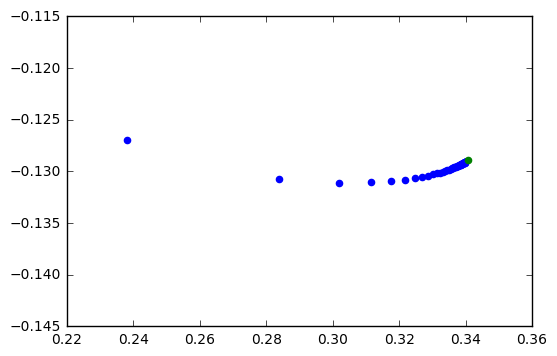

In [78]:
#extract PCA components
u_x=pca.components_[0,:] 
u_y=pca.components_[1,:] 
u_z = (v_pi_scaled-v_mc_scaled) / np.sqrt(((v_pi_scaled-v_mc_scaled).T.dot(D).dot((v_pi_scaled-v_mc_scaled))))

#Project on the principal plane and 
v_td_scaled_proj_x=u_x.dot((v_td_scaled).T)
v_td_scaled_proj_y=u_y.dot((v_td_scaled).T)
v_td_scaled_proj_z=u_z.dot((v_td_scaled).T)

v_k_scaled_proj_x=u_x.dot((v_k_scaled).T)
v_k_scaled_proj_y=u_y.dot((v_k_scaled).T)
v_k_scaled_proj_z=u_z.dot((v_k_scaled).T)

#These bounds and ranges can be used to scale the plot axis
mean_x  = np.mean(v_td_scaled_proj_x)
mean_y  = np.mean(v_td_scaled_proj_y)
range_x = np.max(v_td_scaled_proj_x) - np.min(v_td_scaled_proj_x)
range_y = np.max(v_td_scaled_proj_y) - np.min(v_td_scaled_proj_y)

#plot the projection of n-step TD
plt.scatter(v_td_scaled_proj_x,v_td_scaled_proj_y,marker='o',color='b') #n-step TD

#These two give the same point
plt.scatter(u_x.dot(v_mc_scaled),u_y.dot(v_mc_scaled),color='g') #Monte Carlo
#plt.scatter(u_x.dot(v_pi_scaled),u_y.dot(v_pi_scaled),color='r') #True value function


#plt.axis([mean_x-range_x,mean_x+range_x,mean_y-range_y,mean_y+range_y]) #use if weird autoscaling

plt.show()

Now, we add an vertical axis, which corresponds to the direction from $v_{\pi}$ to its projection

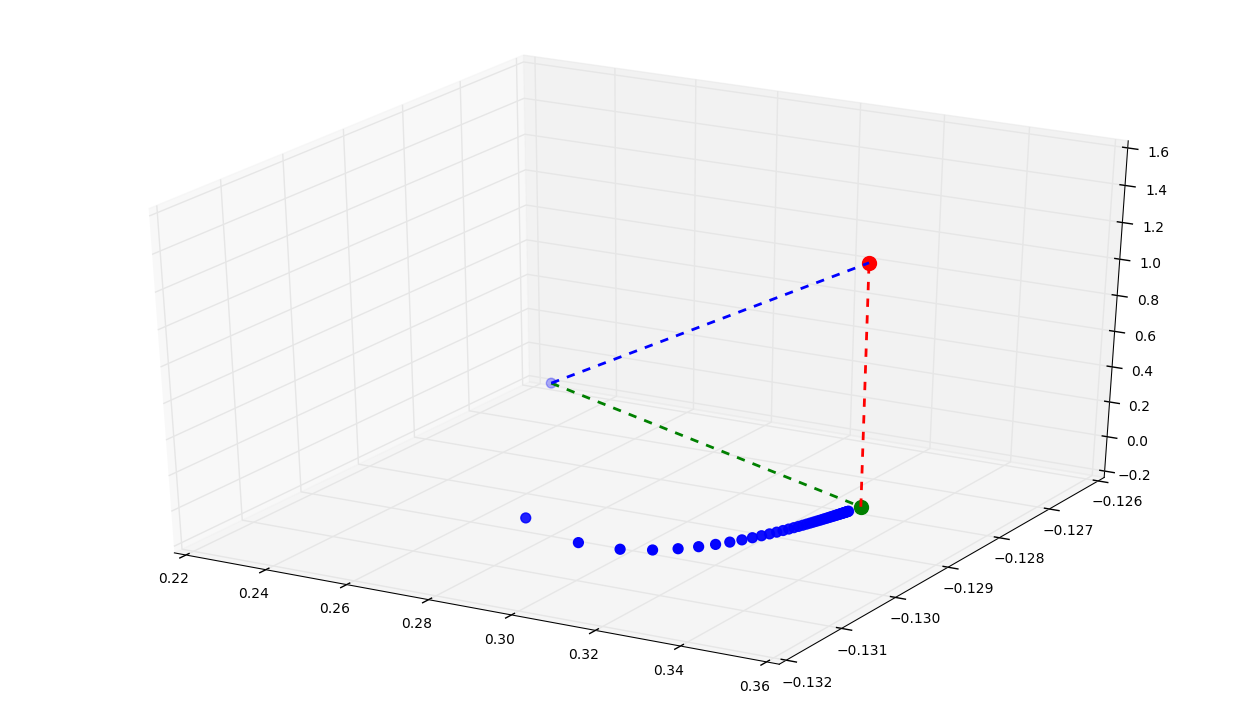

In [80]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')

#plot the n-step TD approximations
ax.scatter(v_td_scaled_proj_x,v_td_scaled_proj_y,v_td_scaled_proj_z,color='b',s=50)
#plot Monte Carlo approximation
ax.scatter(u_x.dot(v_mc_scaled),u_y.dot(v_mc_scaled),0.0,color='g',marker='o',s=100)
#plot true value function
ax.scatter(u_x.dot(v_pi_scaled),u_y.dot(v_pi_scaled),u_z.dot(v_pi_scaled),color='r',s=100)
#draw a line between v_pi_scaled and the MC approximation
ax.plot([u_x.dot(v_mc_scaled),u_x.dot(v_pi_scaled)],
        [u_y.dot(v_mc_scaled),u_y.dot(v_pi_scaled)],
        [0.0,u_z.dot(v_pi_scaled)],'r--',lw=2)

ax.plot([v_td_scaled_proj_x[0],u_x.dot(v_mc_scaled)],
        [v_td_scaled_proj_y[0],u_y.dot(v_mc_scaled)],
        [0.0,0.0],'g--',lw=2)

ax.plot([v_td_scaled_proj_x[0],u_x.dot(v_pi_scaled)],
        [v_td_scaled_proj_y[0],u_y.dot(v_pi_scaled)],
        [0.0,u_z.dot(v_pi_scaled)],'b--',lw=2)


#set axis
#ax.set_xlim([mean_x-range_x,mean_x+range_x])
#ax.set_ylim([mean_y-range_y,mean_y+range_y])
#ax.set_zlim([1.5*np.min([0,u_z.dot(v_pi_scaled)]),1.5*np.max([0,u_z.dot(v_pi_scaled)])])
plt.show()

For n-step TD, we thus have :
\begin{align}
\color{blue}{MSVE(\theta_{TD})} & = \color{red}{MSVE(\theta_{MC})} + \color{green}{\| \Phi \theta_{TD} - \Phi \theta_{MC} \|_{D}^{2}} \\
&\leq \color{red}{MSVE(\theta_{MC})} + \gamma^{n} \cdot \color{blue}{MSVE(\theta_{TD})} 
\end{align}

And recall the error bound :
$$\boxed{\ \ \ 
\color{blue}{MSVE(\theta_{TD})} \leq \frac{1}{1-\gamma^{n}} \color{red}{MSVE(\theta_{MC})}
\ \ \ }
$$